In [1]:
# import argparse

# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

#Choose GRU or LSTM here

rnn = "GRU"
#rnn = "LSTM"

In [2]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_rnn import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State



/home/alinjar/simple_training_warm_start/RNN


In [3]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float())
                

In [4]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [5]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=2.0
a_max=4.0
j_max=10.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 5
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=-np.pi
theta_init_max=np.pi

In [6]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*20 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start))

inp_val = np.hstack(( xi_val, theta_init, v_start))

Using cuda device


In [8]:
print("inp_mean", inp.mean())
print("inp_std", inp.std())

inp_mean -0.00021612548686851649
inp_std 1.170775849409243


In [9]:

# A Torch version of the same is used in decoder function of corresponding MLP class for training
#Statistical Parameters:Median, Q1, Q3, IQR for all features

inp_median_ = np.median(inp, axis=0)
inp_q1 = np.percentile(inp, 25, axis=0)
inp_q3 = np.percentile(inp, 75, axis=0)
inp_iqr_ = inp_q3 - inp_q1


# Handle constant features
inp_iqr_ = np.where(inp_iqr_ == 0, 1, inp_iqr_)

print("input shape: ", inp.shape)
print(inp_median_.shape)
print(inp_q1.shape)
print(inp_q3.shape)
print(inp_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))


inp_val_median_ = np.median(inp_val, axis=0)
inp_val_q1 = np.percentile(inp_val, 25, axis=0)
inp_val_q3 = np.percentile(inp_val, 75, axis=0)
inp_val_iqr_ = inp_val_q3 - inp_val_q1


# Handle constant features
inp_val_iqr_ = np.where(inp_val_iqr_ == 0, 1, inp_val_iqr_)

print("input shape: ", inp_val.shape)
print(inp_val_median_.shape)
print(inp_val_q1.shape)
print(inp_val_q3.shape)
print(inp_val_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))



input shape:  (20000, 52)
(52,)
(52,)
(52,)
(52,)
input shape:  (20000, 52)
(52,)
(52,)
(52,)
(52,)


In [10]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start)
val_dataset = TrajDataset(inp_val, theta_init, v_start)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [11]:

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Training with GRU


In [12]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [13]:


model = MLPProjectionFilter(mlp=mlp,rnn_context=rnn_context, rnn_init = rnn_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection, rnn=rnn).to(device)

print(type(model))                            

<class 'mlp_singledof_rnn.MLPProjectionFilter'>


In [14]:
epochs = 100
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start, rnn)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start, rnn)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        print(f"Train Loss: {np.average(losses_train):.4f}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_{rnn}.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 20/20 [00:00<00:00, 83.60it/s]


Epoch: 1
Train Loss: 11.9697


100%|██████████| 20/20 [00:00<00:00, 92.69it/s]


Epoch: 3
Train Loss: 8.6687


100%|██████████| 20/20 [00:00<00:00, 90.62it/s]


Epoch: 5
Train Loss: 5.4435


100%|██████████| 20/20 [00:00<00:00, 91.74it/s]


Epoch: 7
Train Loss: 2.8832


100%|██████████| 20/20 [00:00<00:00, 92.52it/s]


Epoch: 9
Train Loss: 1.7272


100%|██████████| 20/20 [00:00<00:00, 67.07it/s]


Epoch: 11
Train Loss: 1.3948


100%|██████████| 20/20 [00:00<00:00, 69.68it/s]


Epoch: 13
Train Loss: 1.2297


100%|██████████| 20/20 [00:00<00:00, 92.23it/s]


Epoch: 15
Train Loss: 1.1317


100%|██████████| 20/20 [00:00<00:00, 92.82it/s]


Epoch: 17
Train Loss: 1.0884


100%|██████████| 20/20 [00:00<00:00, 92.00it/s]


Epoch: 19
Train Loss: 1.0676


100%|██████████| 20/20 [00:00<00:00, 89.10it/s]


Epoch: 21
Train Loss: 1.0453


100%|██████████| 20/20 [00:00<00:00, 92.13it/s]


Epoch: 23
Train Loss: 1.0077


100%|██████████| 20/20 [00:00<00:00, 68.29it/s]


Epoch: 25
Train Loss: 1.0048


100%|██████████| 20/20 [00:00<00:00, 67.89it/s]


Epoch: 27
Train Loss: 1.0081


100%|██████████| 20/20 [00:00<00:00, 91.77it/s]


Epoch: 29
Train Loss: 0.9773


100%|██████████| 20/20 [00:00<00:00, 92.53it/s]


Epoch: 31
Train Loss: 0.9879


100%|██████████| 20/20 [00:00<00:00, 88.98it/s]


Epoch: 33
Train Loss: 0.9603


100%|██████████| 20/20 [00:00<00:00, 92.87it/s]


Epoch: 35
Train Loss: 0.9592


100%|██████████| 20/20 [00:00<00:00, 91.19it/s]


Epoch: 37
Train Loss: 0.9627


100%|██████████| 20/20 [00:00<00:00, 66.31it/s]


Epoch: 39
Train Loss: 0.9748


100%|██████████| 20/20 [00:00<00:00, 68.26it/s]


Epoch: 41
Train Loss: 0.9895


100%|██████████| 20/20 [00:00<00:00, 93.44it/s]


Epoch: 43
Train Loss: 0.9496


100%|██████████| 20/20 [00:00<00:00, 91.79it/s]


Epoch: 45
Train Loss: 0.9343


100%|██████████| 20/20 [00:00<00:00, 92.58it/s]


Epoch: 47
Train Loss: 0.9460


100%|██████████| 20/20 [00:00<00:00, 92.61it/s]


Epoch: 49
Train Loss: 0.9156


100%|██████████| 20/20 [00:00<00:00, 92.30it/s]


Epoch: 51
Train Loss: 0.9318


100%|██████████| 20/20 [00:00<00:00, 67.48it/s]


Epoch: 53
Train Loss: 0.9281


100%|██████████| 20/20 [00:00<00:00, 68.45it/s]


Epoch: 55
Train Loss: 0.9446


100%|██████████| 20/20 [00:00<00:00, 92.17it/s]


Epoch: 57
Train Loss: 0.9153


100%|██████████| 20/20 [00:00<00:00, 93.32it/s]


Epoch: 59
Train Loss: 0.9259


100%|██████████| 20/20 [00:00<00:00, 92.52it/s]


Epoch: 61
Train Loss: 0.9128


100%|██████████| 20/20 [00:00<00:00, 92.58it/s]


Epoch: 63
Train Loss: 0.9141


100%|██████████| 20/20 [00:00<00:00, 92.11it/s]


Epoch: 65
Train Loss: 0.9268


100%|██████████| 20/20 [00:00<00:00, 91.52it/s]


Epoch: 67
Train Loss: 0.9111


100%|██████████| 20/20 [00:00<00:00, 66.64it/s]


Epoch: 69
Train Loss: 0.9075


100%|██████████| 20/20 [00:00<00:00, 68.51it/s]


Epoch: 71
Train Loss: 0.8988


100%|██████████| 20/20 [00:00<00:00, 89.50it/s]


Epoch: 73
Train Loss: 0.8931


100%|██████████| 20/20 [00:00<00:00, 92.83it/s]


Epoch: 75
Train Loss: 0.8908


100%|██████████| 20/20 [00:00<00:00, 87.93it/s]


Epoch: 77
Train Loss: 0.9071


100%|██████████| 20/20 [00:00<00:00, 91.44it/s]


Epoch: 79
Train Loss: 0.8928


100%|██████████| 20/20 [00:00<00:00, 91.75it/s]


Epoch: 81
Train Loss: 0.8975


100%|██████████| 20/20 [00:00<00:00, 68.15it/s]


Epoch: 83
Train Loss: 0.8876


100%|██████████| 20/20 [00:00<00:00, 68.93it/s]


Epoch: 85
Train Loss: 0.8972


100%|██████████| 20/20 [00:00<00:00, 92.54it/s]


Epoch: 87
Train Loss: 0.8774


100%|██████████| 20/20 [00:00<00:00, 91.72it/s]


Epoch: 89
Train Loss: 0.8806


100%|██████████| 20/20 [00:00<00:00, 92.32it/s]


Epoch: 91
Train Loss: 0.8786


100%|██████████| 20/20 [00:00<00:00, 92.55it/s]


Epoch: 93
Train Loss: 0.8849


100%|██████████| 20/20 [00:00<00:00, 91.26it/s]


Epoch: 95
Train Loss: 0.8682


100%|██████████| 20/20 [00:00<00:00, 67.90it/s]


Epoch: 97
Train Loss: 0.8687


100%|██████████| 20/20 [00:00<00:00, 68.20it/s]


Epoch: 99
Train Loss: 0.8879


100%|██████████| 20/20 [00:00<00:00, 59.07it/s]


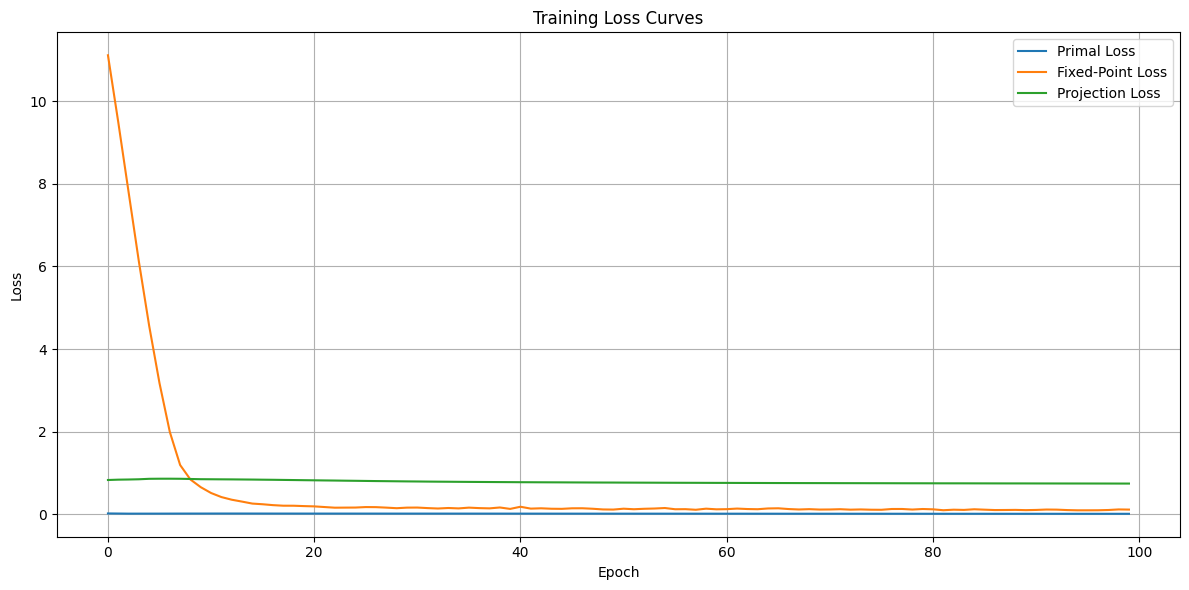

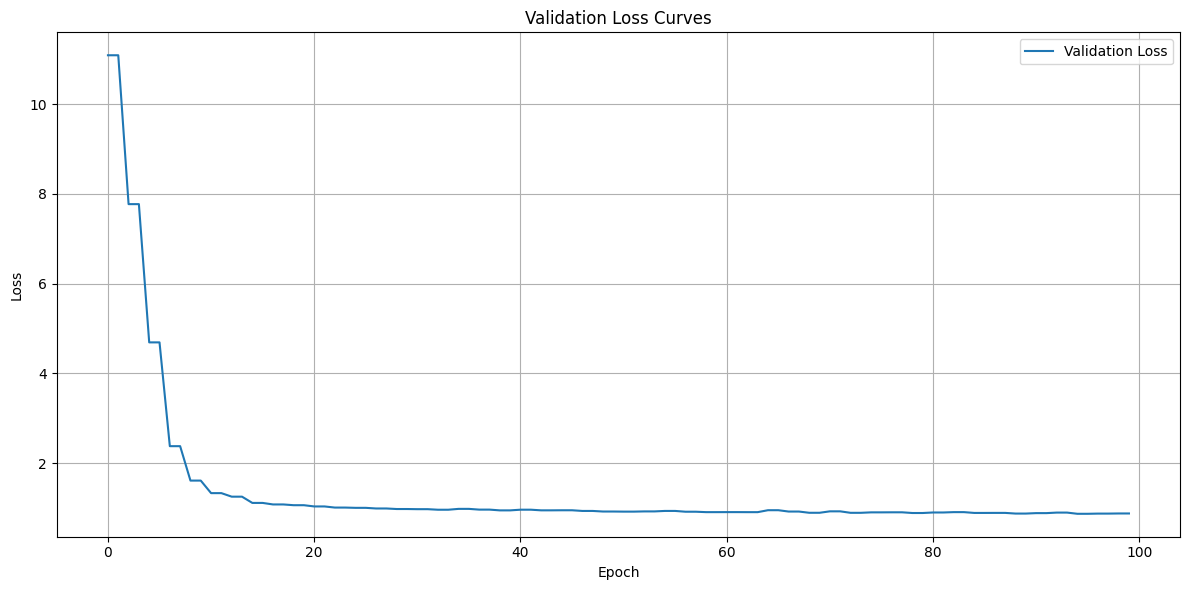

In [15]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

print("max projection_loss", np.max(np.asarray(avg_projection_loss)))
print("min projection_loss", np.min(np.asarray(avg_projection_loss)))

Training_loss_end 0.8838504
Validation_loss_end 0.8793278
max projection_loss 0.8657858
min projection_loss 0.74828714
